In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



# Import required libraries
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np


In [2]:
class ConflictClassifier:
    def __init__(self):
        self.models = {}
        self.best_model = None
        self.best_score = 0
    
    def initialize_models(self):
        """Initialize all classification models"""
        self.models = {
            'random_forest': RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            ),
            'logistic_regression': LogisticRegression(
                random_state=42,
                max_iter=1000
            ),
            'svm': SVC(
                kernel='rbf',
                probability=True,
                random_state=42
            ),
            'xgboost': xgb.XGBClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                eval_metric='logloss'
            ),
            'lightgbm': lgb.LGBMClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                verbose=-1
            )
        }
    
    def evaluate_model(self, model, X_test, y_test):
        """Evaluate model performance"""
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba)
        }
        
        return metrics
    
    def train_and_evaluate(self, X_train, X_test, y_train, y_test, experiment_name="conflict_classification"):
        """Train and evaluate all models with MLflow tracking"""
        self.initialize_models()
        
        
        
        mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
        #mlflow.set_tracking_uri("file:./mlruns")
        mlflow.set_experiment("conflict_classification")
       # with mlflow.start_run(run_name=model_name):
        with mlflow.start_run():
            #mlflow.log_param("param1", 5)
            #mlflow.log_metric("metric1", 0.85)
        
        
        
            mlflow.set_experiment(experiment_name)
        
        results = {}
        
        for model_name, model in self.models.items():
            with mlflow.start_run(run_name=model_name):
                mlflow.set_tag("mlflow.runName", model_name)
                mlflow.log_param("model_name", model_name)
                # Train model
                model.fit(X_train, y_train)
                
                # Evaluate model
                metrics = self.evaluate_model(model, X_test, y_test)
                results[model_name] = metrics
                
                # Log parameters
                if hasattr(model, 'get_params'):
                    params = model.get_params()
                    mlflow.log_params(params)
                
                # Log metrics
                mlflow.log_metrics(metrics)
                
                # Log model
                if model_name in ['xgboost']:
                    mlflow.xgboost.log_model(model, "model")
                elif model_name in ['lightgbm']:
                    mlflow.lightgbm.log_model(model, "model")
                else:
                    #mlflow.sklearn.log_model(model, "model")
                    mlflow.sklearn.log_model(model, "model")
                    run_id = mlflow.active_run().info.run_id
                    model_uri = f"runs:/{run_id}/model"
                    mlflow.register_model(model_uri, "conflict_classifier")
                
                # Track best model
                if metrics['f1_score'] > self.best_score:
                    self.best_score = metrics['f1_score']
                    self.best_model = model
                
                print(f"{model_name} - F1 Score: {metrics['f1_score']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}")
        
        return results
    
    def get_feature_importance(self, feature_names):
        """Get feature importance from the best model"""
        if self.best_model is None:
            return None
        
        if hasattr(self.best_model, 'feature_importances_'):
            importance = self.best_model.feature_importances_
            feature_importance = dict(zip(feature_names, importance))
            return sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        
        return None

In [3]:
# Load dataset
df = pd.read_csv('../data/ssma.csv')

In [4]:
df.head(), df.shape

(   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
 0           1   19  Female  Undergraduate  Bangladesh                    5.2   
 1           2   22    Male       Graduate       India                    2.1   
 2           3   20  Female  Undergraduate         USA                    6.0   
 3           4   18    Male    High School          UK                    3.0   
 4           5   21    Male       Graduate      Canada                    4.5   
 
   Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
 0          Instagram                          Yes                    6.5   
 1            Twitter                           No                    7.5   
 2             TikTok                          Yes                    5.0   
 3            YouTube                           No                    7.0   
 4           Facebook                          Yes                    6.0   
 
    Mental_Health_Score Relationship_Status  Con

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Student_ID                    705 non-null    int64  
 1   Age                           705 non-null    int64  
 2   Gender                        705 non-null    object 
 3   Academic_Level                705 non-null    object 
 4   Country                       705 non-null    object 
 5   Avg_Daily_Usage_Hours         705 non-null    float64
 6   Most_Used_Platform            705 non-null    object 
 7   Affects_Academic_Performance  705 non-null    object 
 8   Sleep_Hours_Per_Night         705 non-null    float64
 9   Mental_Health_Score           705 non-null    int64  
 10  Relationship_Status           705 non-null    object 
 11  Conflicts_Over_Social_Media   705 non-null    int64  
 12  Addicted_Score                705 non-null    int64  
dtypes: fl

In [6]:
def preprocess_data(df):
    
    # Drop Student ID if not required
    df = df.drop(columns=['Student_ID'])
    
    # Encode binary categorical variables
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
    df['Affects_Academic_Performance'] = df['Affects_Academic_Performance'].map({'Yes': 1, 'No': 0})
    
    # Use target encoding for high-cardinality categorical variables
    from sklearn.preprocessing import LabelEncoder
    
    # For Country, use target encoding instead of one-hot encoding
    country_encoder = LabelEncoder()
    df['Country_encoded'] = country_encoder.fit_transform(df['Country'])
    
    # For other categorical variables, use one-hot encoding
    categorical_vars = ['Academic_Level', 'Most_Used_Platform', 'Relationship_Status']
    
    # Numerical variables
    numerical_vars = [
        'Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 
        'Mental_Health_Score', 'Country_encoded'
    ]
    
    # Define transformers
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_vars),
            ('cat', categorical_transformer, categorical_vars)
        ])
    
    X = df.drop(columns=['Conflicts_Over_Social_Media', 'Addicted_Score', 'Country'])
     #Converting  multiclass conflict to binary and defining threshold for high vs low conflicts
    conflict_threshold = 2  # threshold can be adjusted as required
    df['Conflicts_Over_Social_Media_Binary'] = (df['Conflicts_Over_Social_Media'] >= conflict_threshold).astype(int)
    
    # Using binary target instead of multiclass
    y_conflict = df['Conflicts_Over_Social_Media_Binary']  # Binary: 0 (Low) vs 1 (High)
    y_addiction = df['Addicted_Score']
    # y_conflict = df['Conflicts_Over_Social_Media']
    # y_addiction = df['Addicted_Score']
    
    X_processed = preprocessor.fit_transform(X)
    
    return X_processed, y_conflict, y_addiction, preprocessor

In [7]:
#print(X_processed.shape)

In [8]:
numerical_vars = ['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score']
categorical_vars = ['Academic_Level', 'Most_Used_Platform', 'Relationship_Status']


def get_feature_names(preprocessor, numerical_vars, categorical_vars):
    # Get names for numeric features
    num_features = numerical_vars
    # Get names for one-hot encoded categorical features
    cat_features = list(
        preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars)
    )
    return num_features + cat_features

In [9]:
#X_processed, y_conflict, y_addiction = preprocess_data(df)
X_processed, y_conflict, y_addiction, preprocessor = preprocess_data(df)
feature_names = get_feature_names(preprocessor, numerical_vars, categorical_vars)


# Verify the lengths match
print(f"Number of features in data: {X_processed.shape[1]}")
print(f"Number of feature names: {len(feature_names)}")
print(f"Feature names: {feature_names}")


Number of features in data: 23
Number of feature names: 22
Feature names: ['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Academic_Level_Graduate', 'Academic_Level_High School', 'Academic_Level_Undergraduate', 'Most_Used_Platform_Facebook', 'Most_Used_Platform_Instagram', 'Most_Used_Platform_KakaoTalk', 'Most_Used_Platform_LINE', 'Most_Used_Platform_LinkedIn', 'Most_Used_Platform_Snapchat', 'Most_Used_Platform_TikTok', 'Most_Used_Platform_Twitter', 'Most_Used_Platform_VKontakte', 'Most_Used_Platform_WeChat', 'Most_Used_Platform_WhatsApp', 'Most_Used_Platform_YouTube', 'Relationship_Status_Complicated', 'Relationship_Status_In Relationship', 'Relationship_Status_Single']


In [10]:
# Load your data
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Use your actual data instead of synthetic data
X_processed, y_conflict, y_addiction, preprocessor = preprocess_data(df)

# Split the actual data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_conflict, test_size=0.2, random_state=42, stratify=y_conflict
)

# Feature selection to reduce dimensionality and focus on most relevant features
selector = SelectKBest(score_func=f_classif, k=15)  # Select top 15 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features_mask = selector.get_support()
selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if selected_features_mask[i]]

print("Selected features:")
for i, feature in enumerate(selected_feature_names):
    print(f"{i+1}. {feature}")

# Initialize and run classifier with selected features
classifier = ConflictClassifier()
results = classifier.train_and_evaluate(X_train_selected, X_test_selected, y_train, y_test)

# Get feature importances for selected features
if classifier.best_model is not None:
    feature_importance = classifier.get_feature_importance(selected_feature_names)
    print("\nFeature Importances (Selected Features):")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance:.4f}")

Selected features:
1. Age
2. Avg_Daily_Usage_Hours
3. Sleep_Hours_Per_Night
4. Mental_Health_Score
5. Academic_Level_Graduate
6. Academic_Level_High School
7. Most_Used_Platform_Facebook
8. Most_Used_Platform_KakaoTalk
9. Most_Used_Platform_LinkedIn
10. Most_Used_Platform_Snapchat
11. Most_Used_Platform_Twitter
12. Most_Used_Platform_YouTube
13. Relationship_Status_Complicated
14. Relationship_Status_Single
🏃 View run gaudy-colt-744 at: http://127.0.0.1:5000/#/experiments/497124844475320190/runs/98f42659e13d446995a7d3b07aad7934
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/497124844475320190


2025/06/29 17:12:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'conflict_classifier'.
2025/06/29 17:12:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_classifier, version 1
Created version '1' of model 'conflict_classifier'.


random_forest - F1 Score: 0.9774, ROC-AUC: 0.9824
🏃 View run random_forest at: http://127.0.0.1:5000/#/experiments/497124844475320190/runs/e5ae6eaa94614302bb15597138732c4b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/497124844475320190


2025/06/29 17:12:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'conflict_classifier' already exists. Creating a new version of this model...
2025/06/29 17:12:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_classifier, version 2
Created version '2' of model 'conflict_classifier'.


logistic_regression - F1 Score: 0.9773, ROC-AUC: 0.9809
🏃 View run logistic_regression at: http://127.0.0.1:5000/#/experiments/497124844475320190/runs/7f51571fb81542198333db91d9e275d5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/497124844475320190


2025/06/29 17:12:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'conflict_classifier' already exists. Creating a new version of this model...
2025/06/29 17:12:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: conflict_classifier, version 3
Created version '3' of model 'conflict_classifier'.


svm - F1 Score: 0.9736, ROC-AUC: 0.9687
🏃 View run svm at: http://127.0.0.1:5000/#/experiments/497124844475320190/runs/6f4abe3ad5694388959e13ea28ac01ab
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/497124844475320190


c:\Users\kola_\Documents\projects\SDS-CP029-social-sphere\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:12:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/06/29 17:12:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


xgboost - F1 Score: 0.9736, ROC-AUC: 0.9916
🏃 View run xgboost at: http://127.0.0.1:5000/#/experiments/497124844475320190/runs/e8efe65f659a488d8babe13180354abd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/497124844475320190


c:\Users\kola_\Documents\projects\SDS-CP029-social-sphere\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kola_\Documents\projects\SDS-CP029-social-sphere\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/06/29 17:13:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


lightgbm - F1 Score: 0.9848, ROC-AUC: 0.9939
🏃 View run lightgbm at: http://127.0.0.1:5000/#/experiments/497124844475320190/runs/81f1caa94bd242788e1174e3a93c410b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/497124844475320190

Feature Importances (Selected Features):
Academic_Level_Graduate: 357.0000
Avg_Daily_Usage_Hours: 311.0000
Sleep_Hours_Per_Night: 295.0000
Mental_Health_Score: 154.0000
Age: 136.0000
Most_Used_Platform_Facebook: 26.0000
Relationship_Status_Single: 22.0000
Most_Used_Platform_KakaoTalk: 21.0000
Most_Used_Platform_Twitter: 3.0000
Most_Used_Platform_YouTube: 1.0000
Academic_Level_High School: 0.0000
Most_Used_Platform_LinkedIn: 0.0000
Most_Used_Platform_Snapchat: 0.0000
Relationship_Status_Complicated: 0.0000


In [11]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


X_test_selected shape: (141, 15)
selected_feature_names length: 14
selected_feature_names: ['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Academic_Level_Graduate', 'Academic_Level_High School', 'Most_Used_Platform_Facebook', 'Most_Used_Platform_KakaoTalk', 'Most_Used_Platform_LinkedIn', 'Most_Used_Platform_Snapchat', 'Most_Used_Platform_Twitter', 'Most_Used_Platform_YouTube', 'Relationship_Status_Complicated', 'Relationship_Status_Single']
Feature count mismatch: 14 names vs 15 features


c:\Users\kola_\Documents\projects\SDS-CP029-social-sphere\venv\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


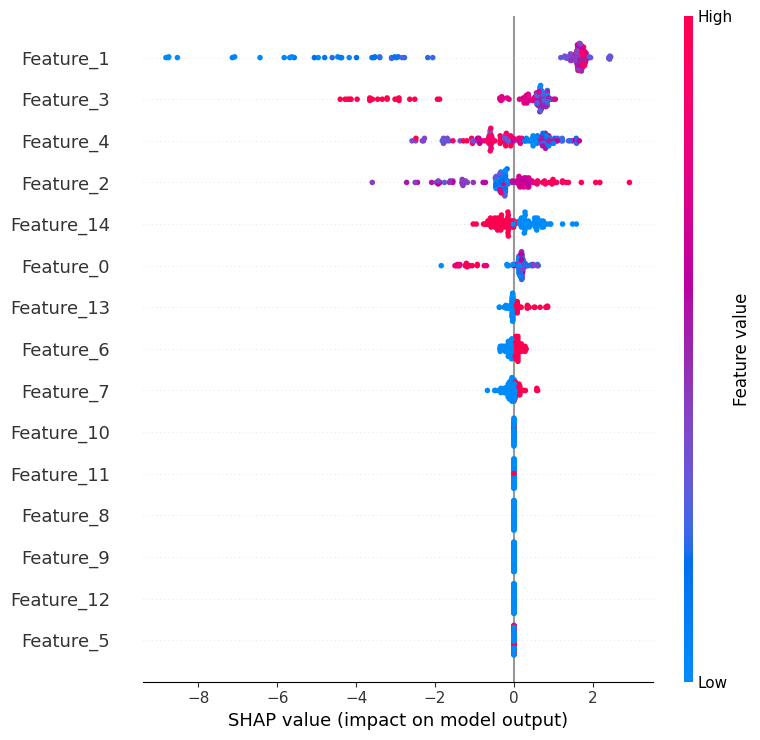

In [12]:
import shap

# Debug: Check dimensions
print(f"X_test_selected shape: {X_test_selected.shape}")
print(f"selected_feature_names length: {len(selected_feature_names)}")
print(f"selected_feature_names: {selected_feature_names}")

# 1. Create SHAP explainer
explainer = shap.TreeExplainer(classifier.best_model)

# 2. Calculate SHAP values
shap_values = explainer.shap_values(X_test_selected)

# 3. Visualize summary plot with proper feature names
if len(selected_feature_names) == X_test_selected.shape[1]:
    shap.summary_plot(shap_values, X_test_selected, feature_names=selected_feature_names)
else:
    print(f"Feature count mismatch: {len(selected_feature_names)} names vs {X_test_selected.shape[1]} features")
    # Create generic feature names as fallback
    generic_names = [f"Feature_{i}" for i in range(X_test_selected.shape[1])]
    shap.summary_plot(shap_values, X_test_selected, feature_names=generic_names)